Episode 50, Total Reward: 15, Total Penalty: -3
Episode 100, Total Reward: 2, Total Penalty: 0
Episode 150, Total Reward: 23, Total Penalty: -3
Episode 200, Total Reward: 35, Total Penalty: -10
Episode 250, Total Reward: 12, Total Penalty: -4
Episode 300, Total Reward: 3, Total Penalty: -1
Episode 350, Total Reward: 13, Total Penalty: -4
Episode 400, Total Reward: 0, Total Penalty: -2
Episode 450, Total Reward: 3, Total Penalty: 0
Episode 500, Total Reward: 4, Total Penalty: -1


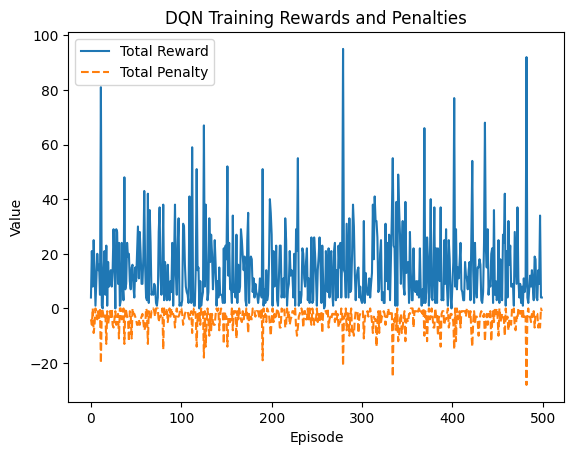

In [ ]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class NightSafetyEnv(gym.Env):
    def __init__(self):
        super(NightSafetyEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(4)  `
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)
        self.state = np.random.rand(5)
        self.done = False

    def reset(self):
        self.state = np.random.rand(5)
        self.done = False
        return self.state

    def step(self, action):
        reward = 0
        penalty = 0

        if action == 0:
            if np.random.rand() > 0.2:
                reward = 1
            else:
                penalty = -1
        elif action == 1:
            if self.state[0] > 0.7:
                reward = 5
            else:
                penalty = -3
        elif action == 2:
            if self.state[1] > 0.5:
                reward = 2
            else:
                penalty = -1
        elif action == 3:
            if self.state[2] > 0.6:
                reward = 3
            else:
                penalty = -2

        total_reward = reward + penalty
        self.state = np.random.rand(5)
        self.done = np.random.rand() > 0.95
        return self.state, total_reward, self.done, {"reward": reward, "penalty": penalty}

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


state_dim = 5
action_dim = 4
model = DQN(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

env = NightSafetyEnv()


episode_rewards = []
episode_penalties = []

for episode in range(500):
    state = env.reset()
    total_reward = 0
    total_penalty = 0
    done = False

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = model(state_tensor)
        action = torch.argmax(q_values).item()

        next_state, reward, done, info = env.step(action)
        total_reward += info["reward"]
        total_penalty += info["penalty"]

        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        with torch.no_grad():
            target_q_values = model(next_state_tensor)

        target_q_value = reward + 0.99 * torch.max(target_q_values).item()


        target = q_values.clone()
        target[0][action] = target_q_value

        loss = criterion(q_values, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    episode_rewards.append(total_reward)
    episode_penalties.append(total_penalty)


    if (episode + 1) % 50 == 0:
        print(f"Episode {episode + 1}, Total Reward: {total_reward}, Total Penalty: {total_penalty}")

plt.plot(episode_rewards, label='Total Reward')
plt.plot(episode_penalties, label='Total Penalty', linestyle='dashed')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('DQN Training Rewards and Penalties')
plt.legend()
plt.show()
